# Task Overdue Classification

The task is to predict whether a request for service will be taken up ontime or not; the goal is to strike a balance between model interpretability and predictive performance; this is because this step is in our opinion more useful as a diagnostic tool to understand which are the requests at highest risk of being overdue as opposed to building a black box model for classification which yields a better performance but does not provide insight into the reasons of the prediction. We believe it is more useful to have a  

In [1]:
import pandas as pd
import numpy as np
import plotly.express as pxs
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import collections
import timeit
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import RandomSampler
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

In [2]:
os.chdir("C:\\Users\Riccardo\Documents\MIT\AEdge\AEdge_Project") 
sr=pd.read_csv("clean_311_service_requests_2019_to_2015.csv")


First of all, we add the clusters from the previous part of the analysis

In [3]:
sr

,case_enquiry_id,open_dt,target_dt,closed_dt,ontime,case_status,case_title,subject,reason,type,...,police_district,neighborhood,neighborhood_services_district,ward,precinct,location_street_name,location_zipcode,latitude,longitude,source
0,101002767856,2019-01-01 00:04:32,2019-01-03 08:30:00,2019-01-02 02:22:29,1,Closed,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,...,B3,Dorchester,9,Ward 17,1701,6-8 School St,2124.0,42.2965,-71.0729,Citizens Connect App
1,101002767857,2019-01-01 00:08:52,2019-01-03 08:30:00,2019-01-02 02:22:11,1,Closed,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,...,D14,Allston / Brighton,15,22,2209,INTERSECTION Eastburn St & Mount Vernon St,NaN,42.3594,-71.0587,Citizens Connect App
2,101002767859,2019-01-01 00:50:00,NaN,2019-11-23 11:36:05,1,Closed,Catchbasin,Boston Water & Sewer Commission,Catchbasin,Catchbasin,...,E13,Jamaica Plain,11,11,1110,195 South St,2130.0,42.3594,-71.0587,Constituent Call
3,101002767861,2019-01-01 01:26:00,NaN,2019-05-17 12:27:07,1,Closed,Fire,Mayor's 24 Hour Hotline,Notification,Notification,...,C11,Dorchester,8,Ward 15,1507,34 Ridgewood St,2122.0,42.3022,-71.0661,Constituent Call
4,101002767862,2019-01-01 01:33:09,2019-01-03 08:30:00,2019-01-02 02:28:35,1,Closed,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,...,B3,Dorchester,9,Ward 17,1701,3 School St,2124.0,42.2968,-71.0727,Citizens Connect App
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200801,101001685663,2015-12-31 22:26:35,2016-01-05 08:30:00,2016-01-04 08:23:06,1,Closed,Request for Pothole Repair,Public Works Department,Highway Maintenance,Request for Pothole Repair,...,E18,Hyde Park,10,Ward 18,1818,INTERSECTION Gordon Ave & River St,NaN,42.2556,-71.1256,Citizens Connect App
1200802,101001685664,2015-12-31 23:00:19,2016-01-05 08:30:00,2016-01-02 07:11:49,1,Closed,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,...,C6,South Boston / South Boston Waterfront,5,Ward 7,0705,212 W Seventh St,2127.0,42.3341,-71.0502,Citizens Connect App
1200803,101001685666,2015-12-31 23:10:09,NaN,2016-01-05 16:32:02,1,Closed,Schedule Bulk Item Pickup,Public Works Department,Sanitation,Schedule a Bulk Item Pickup SS,...,D4,Roxbury,13,Ward 9,0903,483 Massachusetts Ave,2118.0,42.3395,-71.0809,Self Service
1200804,101001685667,2015-12-31 23:12:30,2016-01-05 08:30:00,2016-01-02 10:18:59,1,Closed,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,...,A1,Boston,14,05,0503,115 Boylston St,2108.0,42.3529,-71.0654,Citizens Connect App


In [4]:
clusters=pd.read_csv("clustered_zc.csv")
cl=clusters.iloc[:,1:3]
cl["cluster"]=cl["cluster"].apply(lambda x: str(x))
sr["cluster"]=sr.merge(cl, how="left", on="location_zipcode")["cluster"]

To create a classification model without endogeneity, one needs to get rid of either closed_dt or target_dt. Further, to separate the effects fìof the effects due to the period and those due to the amount of time a task is predicted to take, we decided to create a new set of variables:
- Year, Month, Day as separate columns for when the request was opened
- Time to Complete measuring the time between when the request is opened and when it is closed

In [5]:
sr.open_dt=pd.to_datetime(sr.open_dt)
sr.target_dt=pd.to_datetime(sr.target_dt)

sr["month"]=sr.open_dt.dt.month.apply(lambda x:str(x))
sr["day"]=sr.open_dt.dt.day.apply(lambda x:str(x))
sr["hour"]=sr.open_dt.dt.hour.apply(lambda x:str(x))
sr["week"]=sr.open_dt.dt.week.apply(lambda x:str(x))
 
sr["ttc"]=sr.target_dt-sr.open_dt #target time to close
sr["ttc"]=sr.ttc.apply(lambda x: x.total_seconds()/3600) #tranform in number of hours

In [6]:
import re
sr.ward=sr.ward.apply(lambda x: str(re.findall("\d+|$",str(x))[0]))
sr.ward=sr.ward.apply(lambda x: "0"+x if len(x)<=1 else x)
sr.ward=sr.ward.apply(lambda x: "nan" if (x=="0" or x=="" or x=="00") else x)

In [7]:
sum(pd.isnull(sr.ttc))==sum(pd.isnull(sr.target_dt)) #check no overflow using total seconds

True

Check variable types and number of uniques\

In [8]:
sr.dtypes;

In [9]:
cols=sr.columns
for col in cols:
    if (sr.dtypes[col]!="float64" and sr.dtypes[col]!="int64"):
        print(col, " has unique levels", len(sr[col].unique()))

open_dt  has unique levels 1063610
target_dt  has unique levels 642021
closed_dt  has unique levels 1071545
case_status  has unique levels 2
case_title  has unique levels 13704
subject  has unique levels 14
reason  has unique levels 52
type  has unique levels 194
queue  has unique levels 185
department  has unique levels 17
fire_district  has unique levels 13
pwd_district  has unique levels 23
city_council_district  has unique levels 12
police_district  has unique levels 25
neighborhood  has unique levels 25
neighborhood_services_district  has unique levels 18
ward  has unique levels 23
precinct  has unique levels 256
location_street_name  has unique levels 127111
source  has unique levels 7
cluster  has unique levels 6
month  has unique levels 12
day  has unique levels 31
hour  has unique levels 24
week  has unique levels 53


Now we can create the final dataset;

In [10]:
sr=sr.dropna(subset=["ontime"])
df=sr.drop(columns=[#drop open_dt and target_dt because information is already captured by the other variables
                    "open_dt", "target_dt",
                    #drop closed_dt because it's what we are trying to predict 
                     "closed_dt",
                    #drop because it's the index
                    "case_enquiry_id", 
                    #drop because of excessive number of levels
                    "location_street_name","case_title",
                    #drop because it's not accurate
                    "case_status",
                    #drop because it's not ordinal and redundant ??
                     "latitude","longitude",
                    #drop zipcode because the same information is captured by the clusters
                    "location_zipcode",
                    # drop  because they are too granular
                    "queue","type","precinct"])

df=df.dropna() #drop everything with NAs


In [11]:
df=df.sample(300000)
df

,ontime,subject,reason,department,fire_district,pwd_district,city_council_district,police_district,neighborhood,neighborhood_services_district,ward,source,cluster,month,day,hour,week,ttc
888594,1,Inspectional Services,Housing,ISD,7,03,4,C11,Dorchester,9,17,Constituent Call,1,7,12,10,28,720.000000
147263,1,Public Works Department,Highway Maintenance,PWDx,4,1C,7,D4,South End,6,04,Employee Generated,2,7,26,9,30,8760.000000
192394,1,Parks & Recreation Department,Trees,PARK,4,1C,2,A1,Boston,4,03,Constituent Call,2,9,16,20,38,8760.007500
889497,1,Public Works Department,Code Enforcement,PWDx,4,1C,2,D4,South End,6,04,Citizens Connect App,2,7,13,11,28,48.000000
810796,1,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,BTDT,3,1A,1,A15,Charlestown,2,02,Citizens Connect App,0,3,8,7,10,24.807222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179810,1,Public Works Department,Code Enforcement,PWDx,1,09,1,A7,East Boston,1,01,Citizens Connect App,2,9,2,15,36,88.968056
632830,1,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,BTDT,3,1B,1,A1,Downtown / Financial District,3,03,Citizens Connect App,3,6,7,15,23,23.999722
367071,1,Public Works Department,Sanitation,PWDx,7,03,4,B3,Greater Mattapan,8,14,Constituent Call,1,5,21,18,21,37.883333
677492,1,Public Works Department,Street Cleaning,PWDx,9,02,6,E13,Jamaica Plain,11,19,City Worker App,0,8,8,8,32,24.054444


Use one hot encoding on the following list of variables:

In [12]:
cols=list(df.columns)
cols

['ontime',
 'subject',
 'reason',
 'department',
 'fire_district',
 'pwd_district',
 'city_council_district',
 'police_district',
 'neighborhood',
 'neighborhood_services_district',
 'ward',
 'source',
 'cluster',
 'month',
 'day',
 'hour',
 'week',
 'ttc']

In [13]:
cols=list(df.columns)
cols.remove("ontime")
categorical_variables=[]
numerical_variables=[]
for col in cols:
    if (df.dtypes[col]!="float64" and df.dtypes[col]!="timedelta64[ns]"):
        categorical_variables.append(col)
    else:
        numerical_variables.append(col)

In [14]:
categorical_variables

['subject',
 'reason',
 'department',
 'fire_district',
 'pwd_district',
 'city_council_district',
 'police_district',
 'neighborhood',
 'neighborhood_services_district',
 'ward',
 'source',
 'cluster',
 'month',
 'day',
 'hour',
 'week']

To make levels more interpretable, I got rid of the levels which do not appear frequently (less than 1% of the observations)

In [15]:
#run only once
def cut_levels(df, var, treshold):
    value_counts = df[var].value_counts()
    labels = value_counts.index[(value_counts/sum(value_counts))<treshold]
    df[var][df[var].isin(labels)] = "other"
    df.drop(columns=var)
    return df[var]


for var in categorical_variables:
    print(var)
    cut_levels(df, var, 0.01)
    print(df[var].unique())      

subject
['Inspectional Services' 'Public Works Department'
 'Parks & Recreation Department' 'Transportation - Traffic Division'
 'Property Management' 'other']
reason


<ipython-input-15-33ddc2cd64d9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var][df[var].isin(labels)] = "other"


['Housing' 'Highway Maintenance' 'Trees' 'Code Enforcement'
 'Enforcement & Abandoned Vehicles' 'Sanitation' 'Street Cleaning'
 'Park Maintenance & Safety' 'Street Lights' 'Recycling' 'Building'
 'other' 'Environmental Services' 'Signs & Signals' 'Graffiti']
department
['ISD' 'PWDx' 'PARK' 'BTDT' 'PROP' 'INFO' 'other']
fire_district
['7' '4' '3' '1' '8' '6' '9' '11' '12' 'other']
pwd_district
['03' '1C' '1A' '09' '10A' '07' '10B' '1B' '05' '06' '04' '02' '08'
 'other']
city_council_district
['4' '7' '2' '1' '8' '3' '6' '9' '5' 'other']
police_district
['C11' 'D4' 'A1' 'A15' 'A7' 'B3' 'B2' 'C6' 'E5' 'E13' 'D14' 'E18' 'other']
neighborhood
['Dorchester' 'South End' 'Boston' 'Charlestown' 'East Boston' 'Back Bay'
 'Fenway / Kenmore / Audubon Circle / Longwood' 'Roxbury'
 'Greater Mattapan' 'Mission Hill' 'Roslindale'
 'Downtown / Financial District' 'West Roxbury' 'Jamaica Plain' 'other'
 'Allston / Brighton' 'Hyde Park' 'South Boston / South Boston Waterfront'
 'Beacon Hill']
neighborhoo

Define train test splits

Use stratified sampling because it's better for calssification purposes

In [16]:
#stratified
def split(X_processed, y):
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_processed, y, stratify=y, test_size=0.2,random_state=500)

    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, stratify=y_trainval, test_size=0.2,random_state=500)
    return X_train, X_val, X_test, y_train, X_trainval, y_trainval, y_val, y_test

In [17]:
X=df.drop(columns=["ontime"])
y=df["ontime"]
X_train, X_valid, X_test, y_train, X_trainval, y_trainval, y_valid, y_test=split(X,y)

Export the dataframe in Julia for OCT modelling

In [18]:
X_trainval.to_csv("X_trainval.csv")
X_test.to_csv("X_test.csv")

y_test.to_csv("y_test.csv")
y_trainval.to_csv("y_trainval.csv")

Create a pipeline to fit classic ML algorihtms. Since the problem of interpretability is very relevant, we chose to prioritize it over performance. For this reason, we fit a CART model as out primary model alongside less interpretable ensemble classification to benchmark performance. In order to maximise interpretability, we first chose to encode the variables through one hot encode

In [19]:
numerical_variables

['ttc']

In [20]:
def encoder(X,y, categorical_variables,numerical_variables):
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='NaN')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
    numerical_imputer= SimpleImputer(strategy='mean')
    X_preprocessor = ColumnTransformer(
        transformers=[('cat', categorical_transformer, categorical_variables), ('num', numerical_imputer, numerical_variables)])
    
    X_processed = X_preprocessor.fit_transform(X)
    col_list=X_preprocessor.transformers_[0][1].named_steps['onehot'].get_feature_names(categorical_variables) 
    
    return X_processed,y ,list(col_list)+ numerical_variables 

Finally, we fit a validated CART model

In [21]:
def CART(X_train, X_val, y_train, y_val, X_trainval, y_trainval, n_trials):
        
    start = timeit.default_timer()
    def objective(trial):
        # Maximum number of levels in tree
        CART_max_depth = trial.suggest_int("CART_max_depth", 3, 7)
        
        ## Minimum number of samples required to split a node
        CART_minbucket = trial.suggest_int("CART_min_bucket", 40, 70)
        
        # Minimum decrease in impurity required for split to happen
        CART_cp = trial.suggest_loguniform("CART_cp", 0.001, 0.1)

        classifier_obj = DecisionTreeClassifier(
            min_impurity_decrease=CART_cp, max_depth=CART_max_depth)
        score = cross_val_score(classifier_obj, X_val, y_val, n_jobs=-1, cv=3)
        accuracy = score.mean()
        return accuracy

    study_CART = optuna.create_study(sampler = RandomSampler(seed=1), direction='maximize')
    study_CART.optimize(objective, n_trials=n_trials)
    
    best_cp= study_CART.best_params['CART_cp']
    best_max_depth = study_CART.best_params['CART_max_depth']
    
    final_CART = DecisionTreeClassifier(
            min_impurity_decrease=best_cp, max_depth=best_max_depth)
    final_CART.fit(X_trainval,y_trainval)
    stop = timeit.default_timer()
    print("time required is:", round((stop-start)/60,2))
    return final_CART

In [22]:
def logit(X_train, X_val, y_train, y_val, X_trainval, y_trainval, n_trials):
        
    start = timeit.default_timer()
    def objective(trial):
        # Grid for regularization parameter
        C = trial.suggest_loguniform("C", 0.01, 1)

        classifier_obj = LogisticRegression(
            C=C)
        score = cross_val_score(classifier_obj, X_val, y_val, n_jobs=-1, cv=3)
        accuracy = score.mean()
        return accuracy

    study_logit = optuna.create_study(sampler = RandomSampler(seed=1), direction='maximize')
    study_logit.optimize(objective, n_trials=n_trials)
    
    best_C= study_logit.best_params['C']
    final_logit = LogisticRegression(
            C=best_C,max_iter=500)
    final_logit.fit(X_trainval,y_trainval)
    stop = timeit.default_timer()
    print("time required is:", round((stop-start)/60,2))
    return final_logit

Run the full pipeline for CART

In [23]:
def full_pipeline(df,categorical_variables,numerical_variables,n_trials):
    
    X=df.drop(columns=["ontime"])
    y=df["ontime"]
    
    X_processed,y, col_list= encoder(X,y, categorical_variables,numerical_variables)
    print("encoder completed; starting splits\n")
    
    X_train, X_val, X_test, y_train, X_trainval, y_trainval, y_val, y_test=split(X_processed,y)
    
    print("split completed; starting validation\n")
    final_CART=CART(X_train, X_val, y_train, y_val, X_trainval, y_trainval, n_trials)
    #final_logit=logit(X_train, X_val, y_train, y_val, X_trainval, y_trainval, n_trials)
    print("pipeline completed!")
    return final_CART, X_trainval, X_test, y_trainval,y_test, col_list

final_CART, X_trainval_enc, X_test_enc, y_trainval_enc, y_test_enc, col_list_enc =full_pipeline(df,categorical_variables,numerical_variables,10)

encoder completed; starting splits



[I 2020-11-22 18:01:14,288] A new study created in memory with name: no-name-59ed86f8-2d3b-48b0-942c-113279200c73


split completed; starting validation



[I 2020-11-22 18:01:21,316] Trial 0 finished with value: 0.7775416666666667 and parameters: {'CART_max_depth': 6, 'CART_min_bucket': 52, 'CART_cp': 0.07330181339535059}. Best is trial 0 with value: 0.7775416666666667.
[I 2020-11-22 18:01:26,489] Trial 1 finished with value: 0.7775416666666667 and parameters: {'CART_max_depth': 4, 'CART_min_bucket': 51, 'CART_cp': 0.099559115738444}. Best is trial 0 with value: 0.7775416666666667.
[I 2020-11-22 18:01:27,979] Trial 2 finished with value: 0.812625 and parameters: {'CART_max_depth': 3, 'CART_min_bucket': 56, 'CART_cp': 0.006210998932353835}. Best is trial 2 with value: 0.812625.
[I 2020-11-22 18:01:28,840] Trial 3 finished with value: 0.7775416666666667 and parameters: {'CART_max_depth': 7, 'CART_min_bucket': 46, 'CART_cp': 0.07431528396574373}. Best is trial 2 with value: 0.812625.
[I 2020-11-22 18:01:30,961] Trial 4 finished with value: 0.8270624999999999 and parameters: {'CART_max_depth': 7, 'CART_min_bucket': 70, 'CART_cp': 0.004232013

time required is: 0.55
pipeline completed!


Get final scores

In [24]:
#coefficients = pd.concat([pd.DataFrame(col_list_enc),pd.DataFrame(np.transpose(final_logit.coef_))], axis = 1)
#coefficients.columns=["Feature", "Coefficient"]
#coefficients.sort_values(by=['Coefficient'])

NameError: name 'final_logit' is not defined

In [25]:
#print("Logit Train Accuracy score: {}\tLogit Test Accurarcy score: {}".format(
 #       final_logit.score(X_trainval_enc, y_trainval_enc),
  #      final_logit.score(X_test_enc, y_test_enc)))

#y_prob_logit=final_logit.predict_proba(X_test_enc)[:,1]
#auc_logit=roc_auc_score(y_test, y_prob_logit)
#print("Logit Test ROC-AUC score: {}".format(auc_logit))

#(fpr_logit, tpr_logit, thresholds_logit) = roc_curve(y_test, y_prob_logit, pos_label=1)
#plt.plot(fpr_logit, fpr_logit, color='green',lw=lw, label='ROC Log Reg (area = %0.2f)' % auc_logit)

NameError: name 'final_logit' is not defined

In [26]:
print("CART Train Accuracy score: {}\tCART Test Accurarcy score: {}".format(
        final_CART.score(X_trainval_enc, y_trainval_enc),
        final_CART.score(X_test_enc, y_test_enc)))

y_prob_cart=final_CART.predict_proba(X_test_enc)[:,1]
auc_cart=roc_auc_score(y_test, y_prob_cart)
print("CART Test ROC-AUC score: {}".format(auc_cart))

CART Train Accuracy score: 0.8239791666666667	CART Test Accurarcy score: 0.8222333333333334
CART Test ROC-AUC score: 0.8089495418111329


Plot the final tree

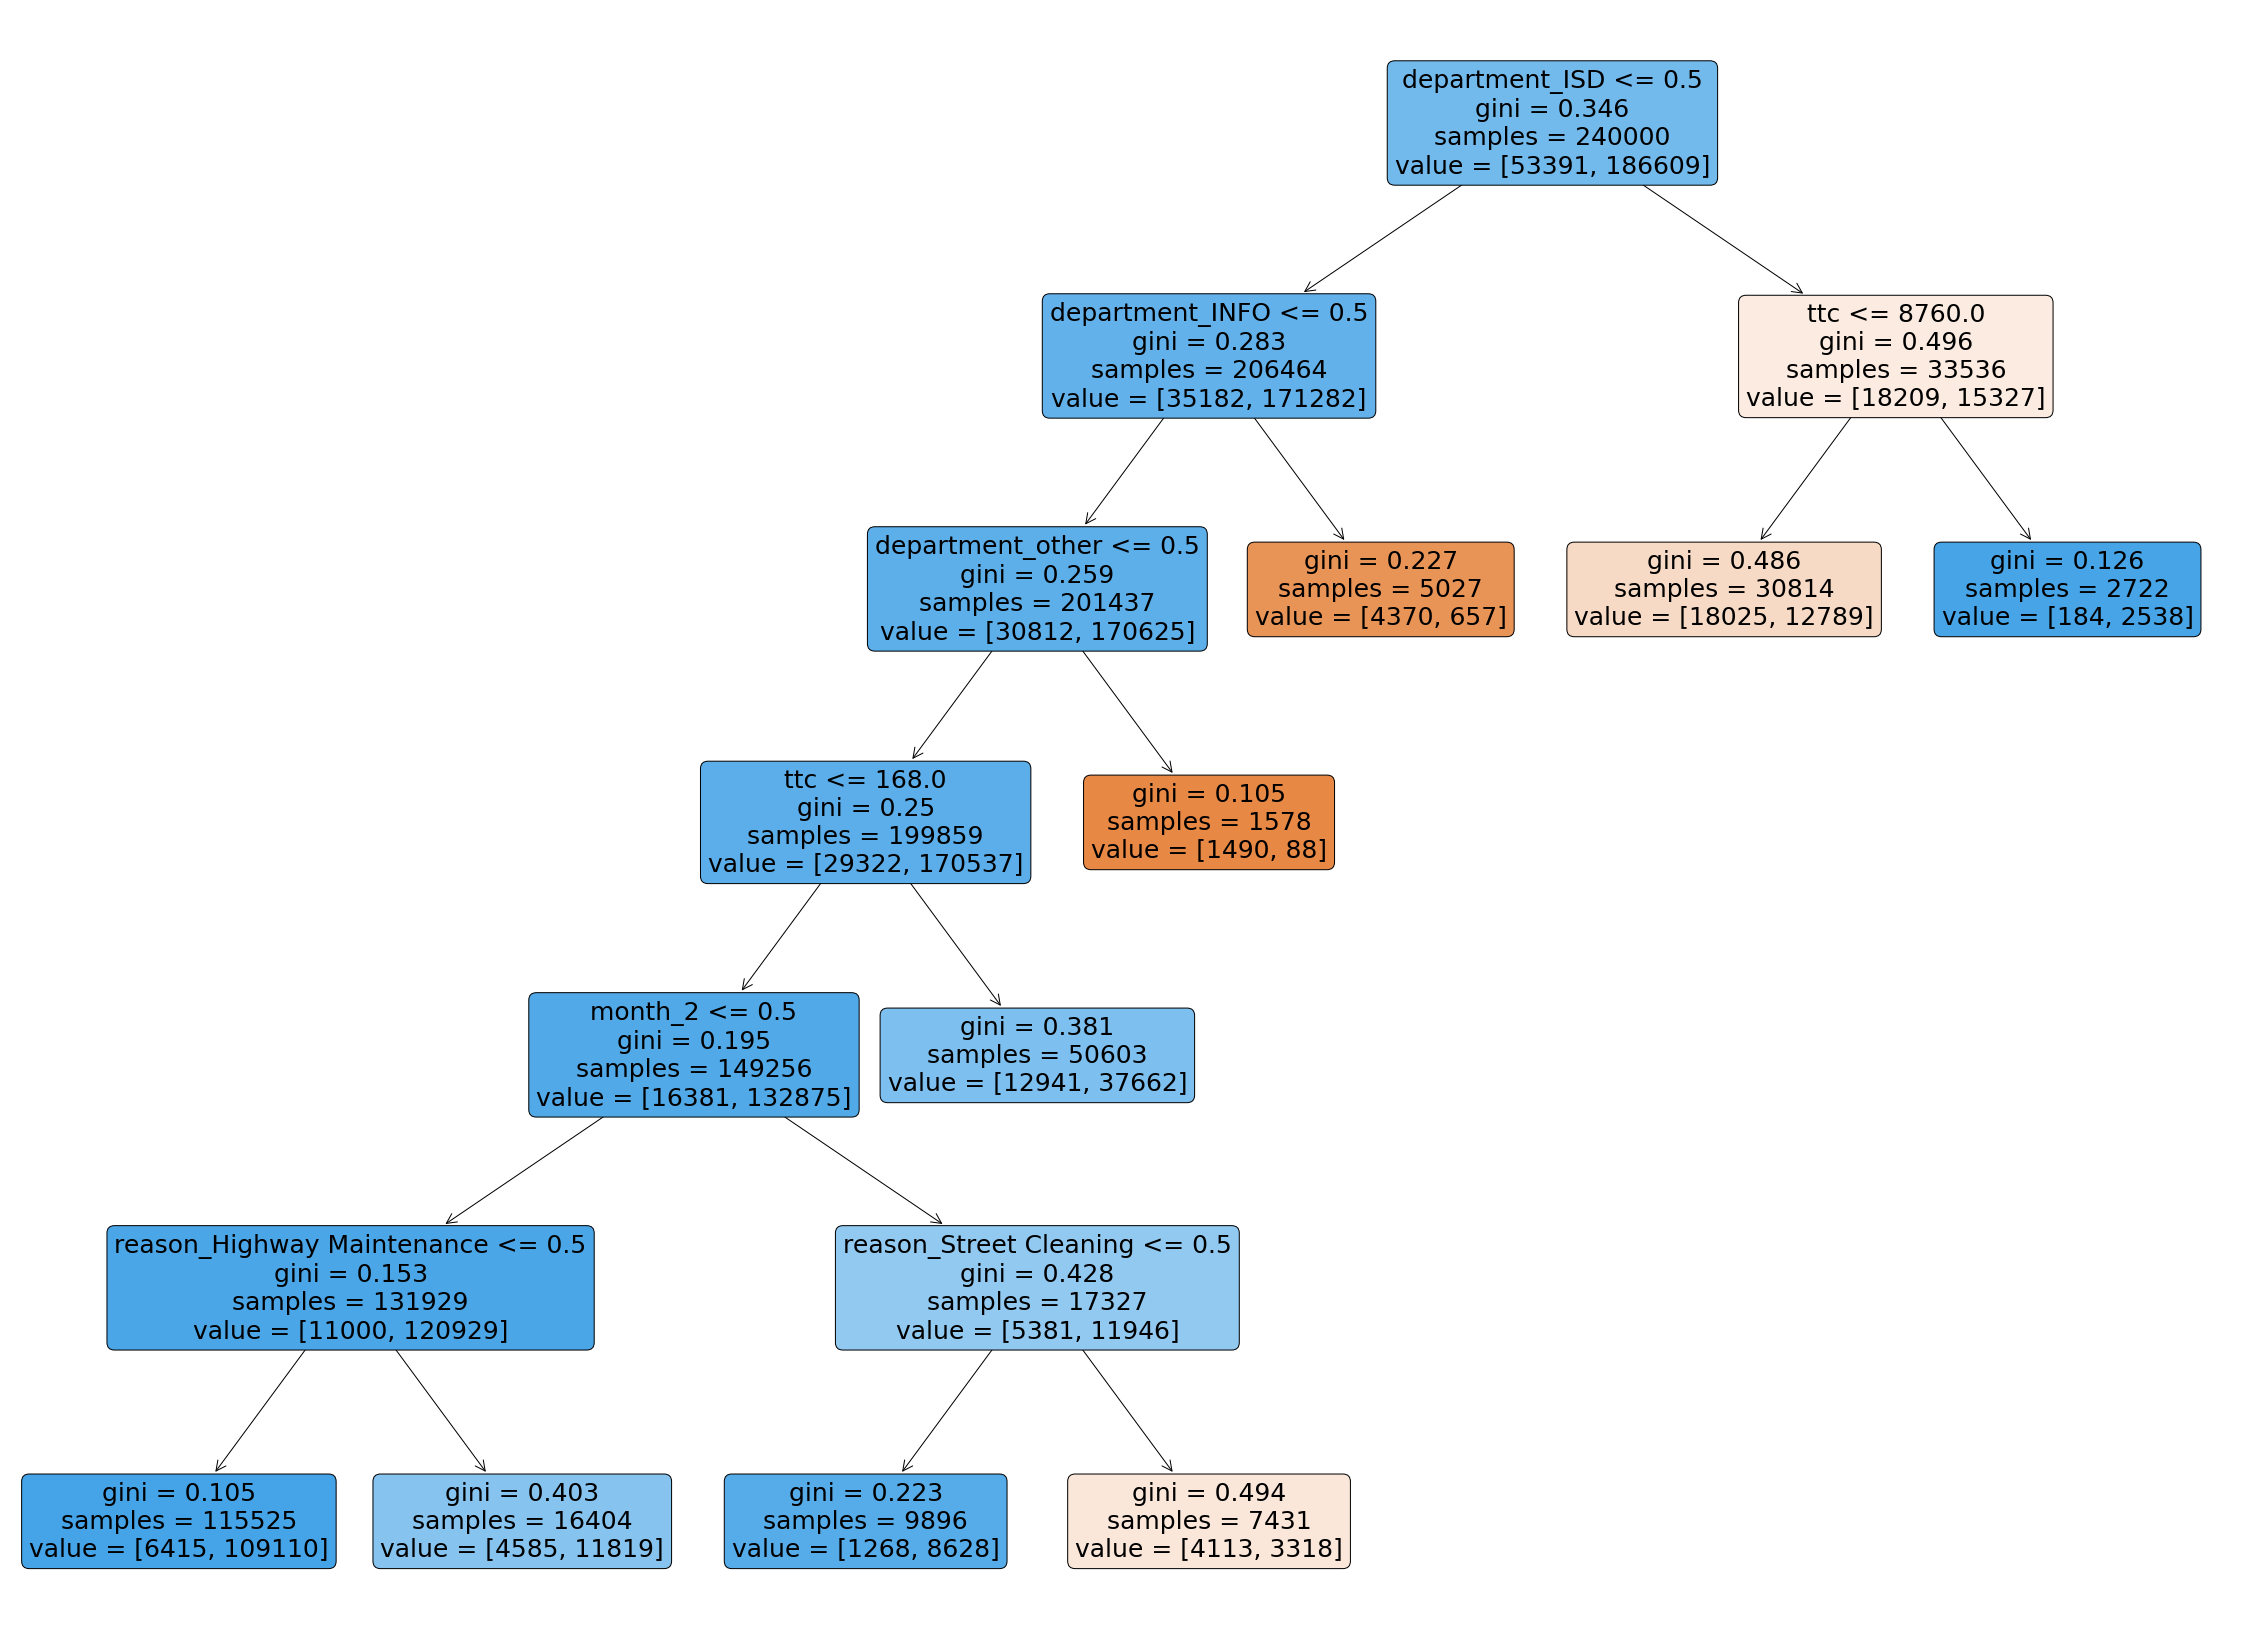

In [48]:
import matplotlib.pyplot as plt
from sklearn import tree
fig = plt.figure(figsize=(40,30))
plot= tree.plot_tree(final_CART, feature_names=col_list_enc,fontsize=25,
                   filled=True,rounded=True)

fig.savefig('CART.png')

In order to get an upper bound of performance for the black box model we used CatBoost, which is a categorical method well known for its ability to deal with categorical variables.

##  Cat Boost

The model is fit with the same split fed to the OCT, since there is no need for one-hot encoding. We don't perform validation because of the computational limitations and because the standard parameters of CatBoost Classifiers tend to be already very good.

In [28]:
cb_model = CatBoostClassifier(iterations = 1000, eval_metric='AUC')
catboost_pool = Pool(X_train, y_train,cat_features=categorical_variables)
cb_model.fit(catboost_pool,
             eval_set=(X_valid,y_valid),
             use_best_model=True,
             verbose=True)

Learning rate set to 0.116114
0:	test: 0.8263304	best: 0.8263304 (0)	total: 655ms	remaining: 10m 54s
1:	test: 0.8330191	best: 0.8330191 (1)	total: 1.19s	remaining: 9m 54s
2:	test: 0.8399362	best: 0.8399362 (2)	total: 1.74s	remaining: 9m 37s
3:	test: 0.8426405	best: 0.8426405 (3)	total: 2.29s	remaining: 9m 31s
4:	test: 0.8468961	best: 0.8468961 (4)	total: 2.77s	remaining: 9m 10s
5:	test: 0.8516395	best: 0.8516395 (5)	total: 3.41s	remaining: 9m 24s
6:	test: 0.8559187	best: 0.8559187 (6)	total: 4.13s	remaining: 9m 45s
7:	test: 0.8580235	best: 0.8580235 (7)	total: 4.76s	remaining: 9m 50s
8:	test: 0.8596683	best: 0.8596683 (8)	total: 5.29s	remaining: 9m 41s
9:	test: 0.8626092	best: 0.8626092 (9)	total: 5.95s	remaining: 9m 48s
10:	test: 0.8649791	best: 0.8649791 (10)	total: 6.6s	remaining: 9m 53s
11:	test: 0.8664065	best: 0.8664065 (11)	total: 7.21s	remaining: 9m 53s
12:	test: 0.8674682	best: 0.8674682 (12)	total: 7.87s	remaining: 9m 57s
13:	test: 0.8686045	best: 0.8686045 (13)	total: 8.51s	

114:	test: 0.9016851	best: 0.9016851 (114)	total: 1m 9s	remaining: 8m 51s
115:	test: 0.9017911	best: 0.9017911 (115)	total: 1m 9s	remaining: 8m 50s
116:	test: 0.9018803	best: 0.9018803 (116)	total: 1m 10s	remaining: 8m 49s
117:	test: 0.9019520	best: 0.9019520 (117)	total: 1m 10s	remaining: 8m 49s
118:	test: 0.9020301	best: 0.9020301 (118)	total: 1m 11s	remaining: 8m 48s
119:	test: 0.9020815	best: 0.9020815 (119)	total: 1m 11s	remaining: 8m 47s
120:	test: 0.9020828	best: 0.9020828 (120)	total: 1m 12s	remaining: 8m 46s
121:	test: 0.9020958	best: 0.9020958 (121)	total: 1m 13s	remaining: 8m 45s
122:	test: 0.9021996	best: 0.9021996 (122)	total: 1m 13s	remaining: 8m 44s
123:	test: 0.9023000	best: 0.9023000 (123)	total: 1m 14s	remaining: 8m 44s
124:	test: 0.9023323	best: 0.9023323 (124)	total: 1m 14s	remaining: 8m 43s
125:	test: 0.9024378	best: 0.9024378 (125)	total: 1m 15s	remaining: 8m 41s
126:	test: 0.9025414	best: 0.9025414 (126)	total: 1m 15s	remaining: 8m 41s
127:	test: 0.9027647	best: 

225:	test: 0.9065742	best: 0.9065742 (225)	total: 2m 19s	remaining: 7m 59s
226:	test: 0.9065720	best: 0.9065742 (225)	total: 2m 20s	remaining: 7m 59s
227:	test: 0.9065777	best: 0.9065777 (227)	total: 2m 21s	remaining: 7m 59s
228:	test: 0.9066389	best: 0.9066389 (228)	total: 2m 22s	remaining: 7m 59s
229:	test: 0.9066683	best: 0.9066683 (229)	total: 2m 23s	remaining: 7m 58s
230:	test: 0.9066918	best: 0.9066918 (230)	total: 2m 23s	remaining: 7m 58s
231:	test: 0.9067164	best: 0.9067164 (231)	total: 2m 24s	remaining: 7m 58s
232:	test: 0.9067394	best: 0.9067394 (232)	total: 2m 25s	remaining: 7m 58s
233:	test: 0.9067385	best: 0.9067394 (232)	total: 2m 25s	remaining: 7m 57s
234:	test: 0.9067495	best: 0.9067495 (234)	total: 2m 26s	remaining: 7m 57s
235:	test: 0.9067603	best: 0.9067603 (235)	total: 2m 27s	remaining: 7m 57s
236:	test: 0.9067743	best: 0.9067743 (236)	total: 2m 28s	remaining: 7m 57s
237:	test: 0.9067839	best: 0.9067839 (237)	total: 2m 28s	remaining: 7m 56s
238:	test: 0.9068040	best

335:	test: 0.9080489	best: 0.9080569 (334)	total: 3m 40s	remaining: 7m 15s
336:	test: 0.9080557	best: 0.9080569 (334)	total: 3m 41s	remaining: 7m 15s
337:	test: 0.9080557	best: 0.9080569 (334)	total: 3m 42s	remaining: 7m 15s
338:	test: 0.9080771	best: 0.9080771 (338)	total: 3m 43s	remaining: 7m 14s
339:	test: 0.9081187	best: 0.9081187 (339)	total: 3m 44s	remaining: 7m 14s
340:	test: 0.9081271	best: 0.9081271 (340)	total: 3m 44s	remaining: 7m 14s
341:	test: 0.9081350	best: 0.9081350 (341)	total: 3m 45s	remaining: 7m 13s
342:	test: 0.9081886	best: 0.9081886 (342)	total: 3m 46s	remaining: 7m 13s
343:	test: 0.9081849	best: 0.9081886 (342)	total: 3m 46s	remaining: 7m 12s
344:	test: 0.9081861	best: 0.9081886 (342)	total: 3m 48s	remaining: 7m 12s
345:	test: 0.9082489	best: 0.9082489 (345)	total: 3m 48s	remaining: 7m 12s
346:	test: 0.9082610	best: 0.9082610 (346)	total: 3m 49s	remaining: 7m 12s
347:	test: 0.9082628	best: 0.9082628 (347)	total: 3m 50s	remaining: 7m 11s
348:	test: 0.9083250	best

445:	test: 0.9091386	best: 0.9091407 (444)	total: 4m 58s	remaining: 6m 10s
446:	test: 0.9091640	best: 0.9091640 (446)	total: 4m 59s	remaining: 6m 10s
447:	test: 0.9091667	best: 0.9091667 (447)	total: 5m	remaining: 6m 10s
448:	test: 0.9091731	best: 0.9091731 (448)	total: 5m 1s	remaining: 6m 9s
449:	test: 0.9091711	best: 0.9091731 (448)	total: 5m 2s	remaining: 6m 9s
450:	test: 0.9091732	best: 0.9091732 (450)	total: 5m 2s	remaining: 6m 8s
451:	test: 0.9091767	best: 0.9091767 (451)	total: 5m 3s	remaining: 6m 8s
452:	test: 0.9091728	best: 0.9091767 (451)	total: 5m 4s	remaining: 6m 7s
453:	test: 0.9091716	best: 0.9091767 (451)	total: 5m 5s	remaining: 6m 7s
454:	test: 0.9091748	best: 0.9091767 (451)	total: 5m 5s	remaining: 6m 6s
455:	test: 0.9091730	best: 0.9091767 (451)	total: 5m 6s	remaining: 6m 5s
456:	test: 0.9091820	best: 0.9091820 (456)	total: 5m 7s	remaining: 6m 5s
457:	test: 0.9091809	best: 0.9091820 (456)	total: 5m 8s	remaining: 6m 5s
458:	test: 0.9091846	best: 0.9091846 (458)	total:

555:	test: 0.9098201	best: 0.9098206 (554)	total: 6m 24s	remaining: 5m 7s
556:	test: 0.9098173	best: 0.9098206 (554)	total: 6m 25s	remaining: 5m 6s
557:	test: 0.9098165	best: 0.9098206 (554)	total: 6m 26s	remaining: 5m 5s
558:	test: 0.9098575	best: 0.9098575 (558)	total: 6m 26s	remaining: 5m 5s
559:	test: 0.9098628	best: 0.9098628 (559)	total: 6m 27s	remaining: 5m 4s
560:	test: 0.9098740	best: 0.9098740 (560)	total: 6m 28s	remaining: 5m 4s
561:	test: 0.9098861	best: 0.9098861 (561)	total: 6m 29s	remaining: 5m 3s
562:	test: 0.9098970	best: 0.9098970 (562)	total: 6m 29s	remaining: 5m 2s
563:	test: 0.9099041	best: 0.9099041 (563)	total: 6m 30s	remaining: 5m 2s
564:	test: 0.9099034	best: 0.9099041 (563)	total: 6m 31s	remaining: 5m 1s
565:	test: 0.9099072	best: 0.9099072 (565)	total: 6m 32s	remaining: 5m
566:	test: 0.9099051	best: 0.9099072 (565)	total: 6m 33s	remaining: 5m
567:	test: 0.9099071	best: 0.9099072 (565)	total: 6m 33s	remaining: 4m 59s
568:	test: 0.9099117	best: 0.9099117 (568)	

665:	test: 0.9103664	best: 0.9103677 (664)	total: 7m 50s	remaining: 3m 56s
666:	test: 0.9103700	best: 0.9103700 (666)	total: 7m 51s	remaining: 3m 55s
667:	test: 0.9103719	best: 0.9103719 (667)	total: 7m 52s	remaining: 3m 54s
668:	test: 0.9103813	best: 0.9103813 (668)	total: 7m 53s	remaining: 3m 54s
669:	test: 0.9103787	best: 0.9103813 (668)	total: 7m 53s	remaining: 3m 53s
670:	test: 0.9103972	best: 0.9103972 (670)	total: 7m 54s	remaining: 3m 52s
671:	test: 0.9104011	best: 0.9104011 (671)	total: 7m 55s	remaining: 3m 51s
672:	test: 0.9103960	best: 0.9104011 (671)	total: 7m 55s	remaining: 3m 51s
673:	test: 0.9103962	best: 0.9104011 (671)	total: 7m 56s	remaining: 3m 50s
674:	test: 0.9104077	best: 0.9104077 (674)	total: 7m 57s	remaining: 3m 49s
675:	test: 0.9104123	best: 0.9104123 (675)	total: 7m 57s	remaining: 3m 49s
676:	test: 0.9104167	best: 0.9104167 (676)	total: 7m 58s	remaining: 3m 48s
677:	test: 0.9104278	best: 0.9104278 (677)	total: 7m 59s	remaining: 3m 47s
678:	test: 0.9104307	best

775:	test: 0.9107237	best: 0.9107440 (767)	total: 9m 15s	remaining: 2m 40s
776:	test: 0.9107240	best: 0.9107440 (767)	total: 9m 16s	remaining: 2m 39s
777:	test: 0.9107266	best: 0.9107440 (767)	total: 9m 17s	remaining: 2m 38s
778:	test: 0.9107268	best: 0.9107440 (767)	total: 9m 17s	remaining: 2m 38s
779:	test: 0.9107307	best: 0.9107440 (767)	total: 9m 18s	remaining: 2m 37s
780:	test: 0.9107404	best: 0.9107440 (767)	total: 9m 19s	remaining: 2m 36s
781:	test: 0.9107426	best: 0.9107440 (767)	total: 9m 20s	remaining: 2m 36s
782:	test: 0.9107448	best: 0.9107448 (782)	total: 9m 20s	remaining: 2m 35s
783:	test: 0.9107517	best: 0.9107517 (783)	total: 9m 21s	remaining: 2m 34s
784:	test: 0.9107533	best: 0.9107533 (784)	total: 9m 22s	remaining: 2m 34s
785:	test: 0.9107525	best: 0.9107533 (784)	total: 9m 23s	remaining: 2m 33s
786:	test: 0.9107522	best: 0.9107533 (784)	total: 9m 24s	remaining: 2m 32s
787:	test: 0.9107500	best: 0.9107533 (784)	total: 9m 24s	remaining: 2m 31s
788:	test: 0.9107486	best

885:	test: 0.9111843	best: 0.9111885 (884)	total: 10m 38s	remaining: 1m 22s
886:	test: 0.9111902	best: 0.9111902 (886)	total: 10m 39s	remaining: 1m 21s
887:	test: 0.9111934	best: 0.9111934 (887)	total: 10m 40s	remaining: 1m 20s
888:	test: 0.9111928	best: 0.9111934 (887)	total: 10m 40s	remaining: 1m 20s
889:	test: 0.9111885	best: 0.9111934 (887)	total: 10m 41s	remaining: 1m 19s
890:	test: 0.9112069	best: 0.9112069 (890)	total: 10m 42s	remaining: 1m 18s
891:	test: 0.9112243	best: 0.9112243 (891)	total: 10m 43s	remaining: 1m 17s
892:	test: 0.9112239	best: 0.9112243 (891)	total: 10m 44s	remaining: 1m 17s
893:	test: 0.9112273	best: 0.9112273 (893)	total: 10m 45s	remaining: 1m 16s
894:	test: 0.9112277	best: 0.9112277 (894)	total: 10m 45s	remaining: 1m 15s
895:	test: 0.9112318	best: 0.9112318 (895)	total: 10m 46s	remaining: 1m 15s
896:	test: 0.9112287	best: 0.9112318 (895)	total: 10m 47s	remaining: 1m 14s
897:	test: 0.9112275	best: 0.9112318 (895)	total: 10m 48s	remaining: 1m 13s
898:	test: 0

995:	test: 0.9114458	best: 0.9114464 (993)	total: 12m 7s	remaining: 2.92s
996:	test: 0.9114394	best: 0.9114464 (993)	total: 12m 7s	remaining: 2.19s
997:	test: 0.9114351	best: 0.9114464 (993)	total: 12m 8s	remaining: 1.46s
998:	test: 0.9114265	best: 0.9114464 (993)	total: 12m 9s	remaining: 730ms
999:	test: 0.9114403	best: 0.9114464 (993)	total: 12m 10s	remaining: 0us

bestTest = 0.9114463771
bestIteration = 993

Shrink model to first 994 iterations.


In [29]:
y_pred_cb = cb_model.predict_proba(X_test)[:,1]
auc_cb=roc_auc_score(y_test, y_pred_cb)
print("AUC Cat Boost is: ", auc_cb)

AUC Cat Boost is:  0.9085322155660498


In [30]:
importance, col_names=list(cb_model.feature_importances_),list(X_train.columns)
data={"imp":importance, "col_names":col_names}
feature_imp=pd.DataFrame(data)

The feature importance graph is quite consistent with the CART and OCT models, although less specific.

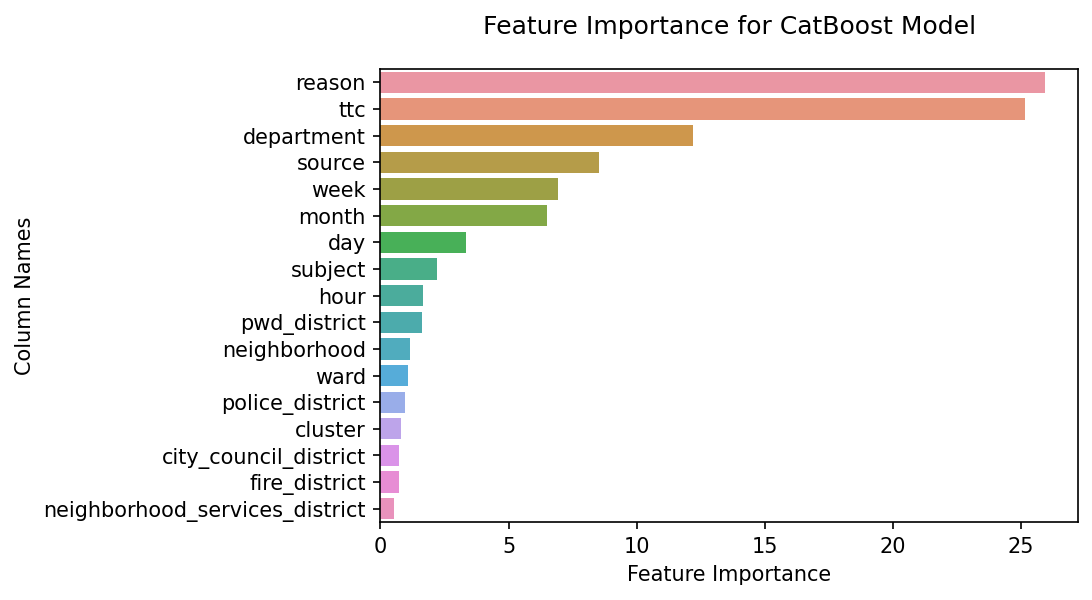

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
fig=plt.figure(dpi=150)
sns.barplot(data=feature_imp.sort_values(by="imp", ascending=False), x="imp",y="col_names")
plt.xlabel('Feature Importance')
plt.ylabel('Column Names')
plt.title('Feature Importance for CatBoost Model', y=1.05)
fig.savefig("CBImportance.png")

In [32]:
y_oct =pd.read_csv("ROC_OCT.csv") #it is important that the script for OCT is run on the same data exported 
                                  #from this noteboook to get comparable results 
y_oct=y_oct.iloc[:,1]
auc_oct=roc_auc_score(y_test, y_oct)
print("AUC OCT is: ", auc_oct)

AUC OCT is:  0.8240141288614933


To get a better idea of the performance of the three models we plot a ROC curve; as expected, the black box benchmark achieves a better performance; nonetheless, both OCT and CART do quite well themeselves.  

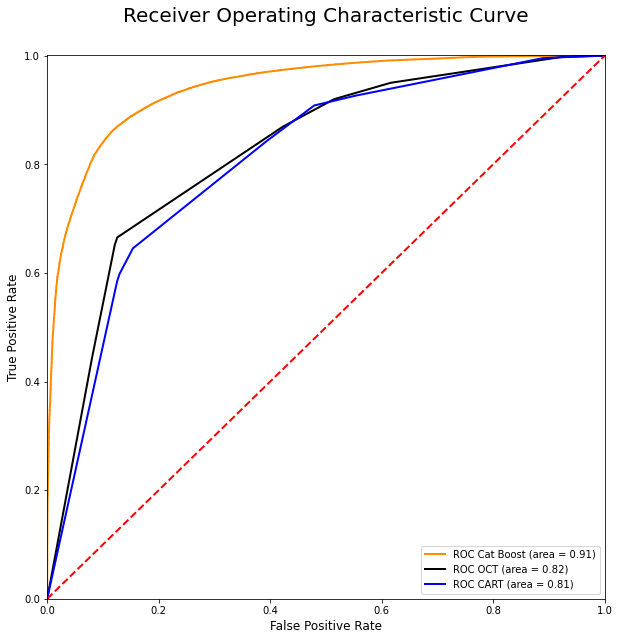

In [44]:
fig=plt.figure(figsize=(10,10))
lw = 2
catboost_pool = Pool(X_train, y_train,cat_features=categorical_variables)
(fpr, tpr, thresholds) = get_roc_curve(cb_model,catboost_pool)


plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC Cat Boost (area = %0.2f)' % auc_cb)

(fpr_OCT, tpr_OCT, thresholds_OCT)=roc_curve(y_test, y_oct)
plt.plot(fpr_OCT, tpr_OCT, color='black'
         ,lw=lw, label='ROC OCT (area = %0.2f)'%auc_oct)

(fpr_cart, tpr_cart, thresholds_cart) = roc_curve(y_test, y_prob_cart, pos_label=1)
plt.plot(fpr_cart, tpr_cart, color='blue',lw=lw, label='ROC CART (area = %0.2f)' % auc_cart)


plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.001])
plt.ylim([0.0, 1.001])

         
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)
plt.title('Receiver Operating Characteristic Curve', fontsize=20,  y=1.05)
plt.legend(loc="lower right")
fig.savefig("ROC_AUC.png")